In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random
import requests
import pickle
import sys
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets

In [2]:
ipywidgets.__version__

'8.0.5'

NOTE: Some cells are commented out or marked as 'raw' because they have been already executed, and we're reading their results as pickled data.

# Functions to query the PDB

In [3]:
def get_pdb_ids(pdb_query):
    base_uri = "https://search.rcsb.org/rcsbsearch/v2/query"
    pdb_rest = f"{base_uri}/?json={pdb_query}"
    response = requests.get(pdb_rest)
    return response    

def get_pdb_details(pdb_id, level="entry",):
    base_uri = "https://data.rcsb.org/rest/v1/core"
    pdb_rest = f"{base_uri}/{level}/{pdb_id}"
    response = requests.get(pdb_rest)
    return response    

In [4]:
def count_entries(df):
    print("Total # records        : ", len(df) )
    print("Unique PDBIDs          : ", len(df.PDB_ID.unique()) )
    print("Membrane Proteins      : ", len(df.loc[ df.IS_MEMBRANE == True ].PDB_ID.unique()))

## Query the PDB

### 1. Retrieve all PROTEINS with Ligands

- Resolution: 0 <= R <= 2.5
- Entry Polymer Type: Protein only
- With Ligand: Compound Identifier *is not* empty
- NO definition of membrane. (Membrane proteins should appear in this search)
- QUERY: Refinement Resolution = [ 0 - 2.5 ] AND Entry Polymer Types = "Protein (only)" AND Component Identifier EXISTS

#### PDB Query:

In [5]:
pdb_query = """
{
  "query": {
    "type": "group",
    "nodes": [
      {
        "type": "terminal",
        "service": "text",
        "parameters": {
          "attribute": "rcsb_entry_info.resolution_combined",
          "value": {
            "from": 0,
            "to": 2.5,
            "include_lower": true,
            "include_upper": true
          },
          "operator": "range"
        }
      },
      {
        "type": "terminal",
        "service": "text",
        "parameters": {
          "attribute": "rcsb_entry_info.selected_polymer_entity_types",
          "operator": "exact_match",
          "negation": false,
          "value": "Protein (only)"
        }
      },
      {
        "type": "terminal",
        "service": "text",
        "parameters": {
          "attribute": "rcsb_nonpolymer_entity_container_identifiers.nonpolymer_comp_id",
          "operator": "exists",
          "negation": false
        }
      }
    ],
    "logical_operator": "and",
    "label": "text"
  },
  "return_type": "entry",
  "request_options": {
    "results_verbosity": "compact",
    "return_all_hits": true,
    "results_content_type": [
      "experimental"
    ]
  }
}
"""

In [6]:
%%time
response = get_pdb_ids(pdb_query).json()
pdb_ids = response['result_set']
len(pdb_ids), random.sample(pdb_ids,5)

CPU times: user 43.4 ms, sys: 3.67 ms, total: 47 ms
Wall time: 995 ms


(105263, ['3S2M', '6LOB', '1ON3', '4XIB', '5TP4'])

### Membrane Proteins

- Membrane Proteins
- Resolution 0.5 <= R <= 2.5
- Entry Polymer Types: Protein (only). 
  (Excludes nucelic acids, oligosaccahrides, and combinations thereof)
- With Ligand: Compound identifier *is not* empty.
- Results in 2,971 PDB IDs.
- QUERY: ( Annotation Type = "PDBTM" OR Annotation Type = "MemProtMD" OR Annotation Type = "OPM" OR Annotation Type = "mpstruc" OR Structure Keywords HAS EXACT PHRASE "MEMBRANE PROTEIN" ) AND Refinement Resolution = [ 0.5 - 2.5 ] AND Entry Polymer Types = "Protein (only)" AND Component Identifier EXISTS


#### PDB Query

In [7]:
pdb_query = """
{
  "query": {
    "type": "group",
    "nodes": [
      {
        "type": "group",
        "logical_operator": "or",
        "nodes": [
          {
            "type": "terminal",
            "service": "text",
            "parameters": {
              "attribute": "rcsb_polymer_entity_annotation.type",
              "operator": "exact_match",
              "value": "PDBTM",
              "negation": false
            }
          },
          {
            "type": "terminal",
            "service": "text",
            "parameters": {
              "attribute": "rcsb_polymer_entity_annotation.type",
              "operator": "exact_match",
              "value": "MemProtMD",
              "negation": false
            }
          },
          {
            "type": "terminal",
            "service": "text",
            "parameters": {
              "attribute": "rcsb_polymer_entity_annotation.type",
              "operator": "exact_match",
              "value": "OPM",
              "negation": false
            }
          },
          {
            "type": "terminal",
            "service": "text",
            "parameters": {
              "attribute": "rcsb_polymer_entity_annotation.type",
              "operator": "exact_match",
              "value": "mpstruc",
              "negation": false
            }
          },
          {
            "type": "terminal",
            "service": "text",
            "parameters": {
              "attribute": "struct_keywords.pdbx_keywords",
              "operator": "contains_phrase",
              "negation": false,
              "value": "MEMBRANE PROTEIN"
            }
          }
        ]
      },
      {
        "type": "terminal",
        "service": "text",
        "parameters": {
          "attribute": "rcsb_entry_info.resolution_combined",
          "value": {
            "from": 0,
            "to": 2.5,
            "include_lower": true,
            "include_upper": true
          },
          "operator": "range"
        }
      },
      {
        "type": "terminal",
        "service": "text",
        "parameters": {
          "attribute": "rcsb_entry_info.selected_polymer_entity_types",
          "operator": "exact_match",
          "negation": false,
          "value": "Protein (only)"
        }
      },
      {
        "type": "terminal",
        "service": "text",
        "parameters": {
          "attribute": "rcsb_nonpolymer_entity_container_identifiers.nonpolymer_comp_id",
          "operator": "exists",
          "negation": false
        }
      }
    ],
    "logical_operator": "and",
    "label": "text"
  },
  "return_type": "entry",
  "request_options": {
    "results_verbosity": "compact",
    "return_all_hits": true,
    "results_content_type": [
      "experimental"
    ]
  }
}
"""

In [8]:
%%time
response = get_pdb_ids(pdb_query).json()
membrane_pdb_ids = response['result_set']
len(membrane_pdb_ids), random.sample(membrane_pdb_ids,5)

CPU times: user 31.1 ms, sys: 2.1 ms, total: 33.2 ms
Wall time: 231 ms


(2995, ['7SPT', '3C33', '1C3W', '6EUQ', '6EHE'])

#### Any membrane proteins *NOT* included in the main set?

In [9]:
missing_mps = list(set(membrane_pdb_ids) - set(pdb_ids))
len(missing_mps)

0

So, all membrane proteins are already included in the main set. Now we can download them all.

# Download all PDB files
(We will filter those later.)

# Filter the Results
There are 104,477 entries in PDB that are PROTEINS and have ligands. However, not all of those are small-molecules of interest. Among the 'ligands' we have:

- (Real) small-molecule ligands of interest
- Crystallization molecules such as GOL, EDO, etc.
- Ions, such as NA, CL, ACT...

There doesn't seem to be any way to filter the results to get only entries with small molecules, so we have to get each entry and filter them here.

#### Definition of non-specific ligands

In [10]:
# Define the 3-letter codes of residues we DON'T want to consiser. 
# For monoatomic ions, we can also filter by the size of the formula
non_spec_ligands = [# -- Common metals, ions and solvents
                    '1PE', # PENTAETHYLENE GLYCOL
                    '2HT', # 3-methylbenzonitrile
                    '2PE', # NONAETHYLENE GLYCOL
                    '7PE', # 2-(2-(2-(2-(2-(2-ETHOXYETHOXY)ETHOXY)ETHOXY)ETHOXY)ETHOXY)ETHANOL
                    'ACT', # ACETATE ION
                    'ACY', # ACETIC ACID
                    'AKG', # 2-OXOGLUTARIC ACID
                    'BCT', # BICARBONATE ION
                    'BR' , # BROMIDE ION
                    'BMA', # beta-D-mannopyranose
                    'BME', # BETA-MERCAPTOETHANOL
                    'BOG', # octyl beta-D-glucopyranoside
                    'BU3', # (R,R)-2,3-BUTANEDIOL
                    'BUD', # (2S,3S)-butane-2,3-diol
                    'CAC', # CACODYLATE ION
                    'CIT', # CITRIC ACID
                    'CME', # S,S-(2-HYDROXYETHYL)THIOCYSTEINE
                    'CO3', # CARBONATE ION
                    'DMS', # DIMETHYL SULFOXIDE
                    'DTT', # 2,3-DIHYDROXY-1,4-DITHIOBUTANE
                    'DTV', # (2S,3S)-1,4-DIMERCAPTOBUTANE-2,3-DIOL
                    'EDO', # 1,2-ETHANEDIOL
                    'EPE', # 4-(2-HYDROXYETHYL)-1-PIPERAZINE ETHANESULFONIC ACID
                    'FES', # FE2/S2 (INORGANIC) CLUSTER
                    'FMT', # FORMIC ACID
                    'GBL', # GAMMA-BUTYROLACTONE
                    'GOL', # GLYCEROL
                    'GSH', # GLUTATHIONE
                    'HEC', # HEME C
                    'HED', # 2-HYDROXYETHYL DISULFIDE
                    'HEM', # PROTOPORPHYRIN IX CONTAINING FE
                    'IMD', # IMIDAZOLE
                    'IOD', # IODIDE ION
                    'IPA', # ISOPROPYL ALCOHOL
                    'MAN', # alpha-D-mannopyranose
                    'MES', # 2-(N-MORPHOLINO)-ETHANESULFONIC ACID
                    'MG8', # N-OCTANOYL-N-METHYLGLUCAMINE
                    'MLI', # MALONATE ION
                    'MPD', # (4S)-2-METHYL-2,4-PENTANEDIOL
                    'MYR', # MYRISTIC ACID
                    'NAG', # 2-acetamido-2-deoxy-beta-D-glucopyranose
                    'NCO', # COBALT HEXAMMINE(III)
                    'NH3', # AMMONIA
                    'NO3', # NITRATE ION
                    'OCT', # N-OCTANE
                    'OGA', # N-OXALYLGLYCINE
                    'OPG', # OXIRANPSEUDOGLUCOSE
                    'P2U', # 2'-DEOXY-PSEUDOURIDINE-5'MONOPHOSPHATE
                    'PEG', # DI(HYDROXYETHYL)ETHER
                    'PG4', # TETRAETHYLENE GLYCOL
                    'PGE', # TRIETHYLENE GLYCOL
                    'PGO', # S-1,2-PROPANEDIOL
                    'PHO', # PHEOPHYTIN A
                    'PI' , # HYDROGENPHOSPHATE ION (INORGANIC PHOSPHATE)
                    'PLP', # PYRIDOXAL-5'-PHOSPHATE
                    'PO4', # PHOSPHATE ION
                    'POP', # PYROPHOSPHATE 2-
                    'PSE', # O-PHOSPHOETHANOLAMINE
                    'PSU', # PSEUDOURIDINE-5'-MONOPHOSPHATE
                    'PTL', # PENTANAL
                    'SCN', # THIOCYANATE ION
                    'SF4', # IRON/SULFUR CLUSTER
                    'F3S', # FE3-S4 CLUSTER
                    'SGM', # MONOTHIOGLYCEROL
                    'SO4', # SULFATE ION
                    'SPD', # SPERMIDINE
                    'SPM', # SPERMINE
                    'SRT', # S,R MESO-TARTARIC ACID
                    'TAM', # TRIS(HYDROXYETHYL)AMINOMETHANE
                    'TAR', # D(-)-TARTARIC ACID
                    'TFA', # trifluoroacetic acid
                    'TLA', # L(+)-TARTARIC ACID
                    'TPP', # THIAMINE DIPHOSPHATE
                    'TRS', # 2-AMINO-2-HYDROXYMETHYL-PROPANE-1,3-DIOL
                    'WO4', # TUNGSTATE(VI)ION
                    # -- Small ligands (MW < 50 D) --
                    'CO2', # CARBON DIOXIDE
                    'PEO', # HYDROGEN PEROXIDE
                    'NH4', # AMMONIUM ION
                    'EOH', # ETHANOL
                    'CCN', # ACETONITRILE
                    'MOH', # METHANOL
                    'NO2', # NITRITE ION
                    'ACE', # ACETYL GROUP
                    'MEE', # METHANETHIOL
                    '74C', # methyl radical
                    'DMN', # DIMETHYLAMINE
                    'FOR', # FORMYL GROUP
                    'H2S', # HYDROSULFURIC ACID
                    'NSM', # NITROSOMETHANE
                    'ARF', # FORMAMIDE
                    'HOA', # HYDROXYAMINE
                    'HZN', # hydrazine
                    'N2O', # NITROUS OXIDE
                    'D3O', # trideuteriooxidanium
                    '0NM', # cyanic acid
                    'NH2', # AMINO GROUP
                    'TME', # PROPANE
                    'C2H', # acetylene
                    'NEH', # ETHANAMINE
                    'NME', # METHYLAMINE
                    'CNN', # CYANAMIDE
                    'BF2', # BERYLLIUM DIFLUORIDE
                    '2NO', # NITROGEN DIOXIDE
                    'MNC', # METHYL ISOCYANIDE
                    'HDN', # METHYLHYDRAZINE
                    ]

In [11]:
len(non_spec_ligands)

105

#### Build DataFrame

In [12]:
def build_pdb_df(pdb_ids, _debug=False):
    pdb_info = pd.DataFrame(columns =["PDB_ID","RESOLUTION","POLY_NAME","POLY_TYPE","POLY_CHAINS","IS_MEMBRANE",
                                      "LIG_ID","LIG_CHAINS","LIG_NAME","LIG_SMILES","LIG_TYPE","LIG_MW","INVESTIGN?"])
    failed = {}
    for pdb_id in tqdm(pdb_ids):

        try:
            if _debug: print('='*60 + pdb_id + '='*60)

            this_data = {}
            pdb_data = get_pdb_details(pdb_id).json()

            is_membrane   = "MEMBRANE" in pdb_data['struct_keywords']['pdbx_keywords']
            n_entities    = pdb_data['rcsb_entry_info']['entity_count']
            n_polymers    = pdb_data['rcsb_entry_info']['polymer_entity_count']
            n_nonpolymers = pdb_data['rcsb_entry_info']['nonpolymer_entity_count']
            n_branched    = pdb_data['rcsb_entry_info']['branched_entity_count']
            n_solvent     = pdb_data['rcsb_entry_info']['solvent_entity_count']

            if _debug:
                print("Entity count:      ", n_entities)
                print("Polymer count:     ", n_polymers)
                print("Non-Polymer count: ", n_nonpolymers)
                print("Branched count:    ", n_branched)
                print("Solvent count:     ", pdb_data['rcsb_entry_info']['solvent_entity_count'])
                print("Membrane protein?  ", is_membrane)

            # Gather polymer data
            polymer_ids = pdb_data['rcsb_entry_container_identifiers']['polymer_entity_ids']
            polymers = []
            for pol_id in polymer_ids:
                this_poly = {}
                poly_data = get_pdb_details(f'{pdb_id}/{pol_id}',level='polymer_entity').json()
                if _debug: print("   Polymer Chains:  ", poly_data['rcsb_polymer_entity_container_identifiers']['auth_asym_ids'])
                this_poly['POLY_NAME'  ] = poly_data['rcsb_polymer_entity']['pdbx_description']
                this_poly['POLY_TYPE'  ] = poly_data['entity_poly']['rcsb_entity_polymer_type']
                this_poly['POLY_CHAINS'] = poly_data['rcsb_polymer_entity_container_identifiers']['auth_asym_ids']
                polymers.append(this_poly)

            # Gather ligand data
            ligands = []

            # Small molecules
            if n_nonpolymers > 0:
                ligands_ids = pdb_data['rcsb_entry_container_identifiers']['non_polymer_entity_ids']
                for lig_id in ligands_ids:
                    this_lig = {}
                    lig_data = get_pdb_details(f'{pdb_id}/{lig_id}',level='nonpolymer_entity').json()
                    this_lig["LIG_ID"    ] = lig_data['pdbx_entity_nonpoly']['comp_id']

                    # Get chemical_component data on this ligand
                    chem_comp_data = get_pdb_details(f'{this_lig["LIG_ID"]}',level='chemcomp').json()

                    # Only proceed if its not monoatomic, and not in the excluded list
                    if (len(chem_comp_data['chem_comp']['formula']) > 3 and this_lig["LIG_ID"] not in non_spec_ligands):

                        if _debug:
                            print("   Ligand Chains:   " , lig_data['rcsb_nonpolymer_entity_container_identifiers']['auth_asym_ids'])
                            print("   Ligands:         " , this_lig["LIG_ID"])

                        this_lig["LIG_NAME"  ] = lig_data['pdbx_entity_nonpoly']['name']
                        this_lig["LIG_CHAINS"] = lig_data['rcsb_nonpolymer_entity_container_identifiers']['auth_asym_ids']
                        this_lig["INVESTIGN?"] = lig_data['rcsb_nonpolymer_entity_feature_summary'][0]['count']

                        this_lig["LIG_MW"    ] = float(chem_comp_data["chem_comp"]["formula_weight"])
                        this_lig["LIG_SMILES"] = chem_comp_data["rcsb_chem_comp_descriptor"]["smilesstereo"]
                        this_lig["LIG_TYPE"  ] = chem_comp_data["chem_comp"]["type"]
                        ligands.append(this_lig)

            # Carbohydrates
            if n_branched > 0:
                ligands_ids = pdb_data['rcsb_entry_container_identifiers']['branched_entity_ids']
                for lig_id in ligands_ids:
                    this_lig = {}
                    lig_data = get_pdb_details(f'{pdb_id}/{lig_id}',level='branched_entity').json()
                    this_lig["LIG_ID"    ] = lig_data['rcsb_branched_entity_container_identifiers']['chem_comp_monomers']

                    # Get chemical_component data on this ligand
                    chem_comp_data = get_pdb_details(f'{this_lig["LIG_ID"][0]}',level='chemcomp').json()

                    # Only proceed if its not monoatomic, and not in the excluded list
                    if (len(chem_comp_data['chem_comp']['formula']) > 3) and this_lig["LIG_ID"] not in non_spec_ligands:

                        if _debug:
                            print("   Branched Chains: ", lig_data['rcsb_branched_entity_container_identifiers']['auth_asym_ids'])
                            print(this_lig["LIG_ID"])

                        this_lig["LIG_NAME"  ] = lig_data['rcsb_branched_entity']['pdbx_description']
                        this_lig["LIG_CHAINS"] = lig_data['rcsb_branched_entity_container_identifiers']['auth_asym_ids']
                        this_lig["INVESTIGN?"] = 0

                        # Get chemical_component data on this ligand
                        this_lig["LIG_MW"    ] = float(chem_comp_data["chem_comp"]["formula_weight"])
                        this_lig["LIG_SMILES"] = chem_comp_data["rcsb_chem_comp_descriptor"]["smilesstereo"]
                        this_lig["LIG_TYPE"  ] = chem_comp_data["chem_comp"]["type"]
                        ligands.append(this_lig)

            # Adds the data to the database
            for polymer in polymers:
                for ligand in ligands:

                    # Populate the dictionary
                    this_data['PDB_ID']     = pdb_id
                    this_data['RESOLUTION'] = pdb_data['rcsb_entry_info']['resolution_combined']
                    this_data['POLY_NAME']  = polymer['POLY_NAME']
                    this_data['POLY_TYPE']  = polymer['POLY_TYPE']
                    this_data['POLY_CHAINS']= list(set(polymer['POLY_CHAINS']))
                    this_data['IS_MEMBRANE']= is_membrane
                    this_data["LIG_ID"]     = ligand["LIG_ID"]
                    this_data["LIG_CHAINS"] = list(set(ligand['LIG_CHAINS']))
                    this_data["LIG_NAME"]   = ligand["LIG_NAME"]
                    this_data["LIG_SMILES"] = ligand["LIG_SMILES"]
                    this_data["LIG_TYPE"]   = ligand["LIG_TYPE"]
                    this_data["LIG_MW"]     = ligand["LIG_MW"]
                    this_data["INVESTIGN?"] = ligand["INVESTIGN?"]
                    pdb_info = pd.concat([pdb_info,pd.DataFrame(this_data)], ignore_index=True)
        except:
            failed[pdb_id] = sys.exc_info()[0]
    return pdb_info, failed

In [13]:
%%time
pdb_info, failed = build_pdb_df(pdb_ids)

  0%|          | 0/105263 [00:00<?, ?it/s]

CPU times: user 4h 8min 5s, sys: 6min 49s, total: 4h 14min 54s
Wall time: 1d 3h 55s


# Looking at the results

The content of the above cells was executed, and the results saved as pickle files. Now we can just read and filter the results from teh pickle files.

In [273]:
pdb_data = pd.read_pickle("pdb_info_df.pkl")

In [274]:
pdb_data

,PDB_ID,RESOLUTION,POLY_NAME,POLY_TYPE,POLY_CHAINS,IS_MEMBRANE,LIG_ID,LIG_CHAINS,LIG_NAME,LIG_SMILES,LIG_TYPE,LIG_MW,INVESTIGN?
0,7OKC,[1.84],Acyl-[acyl-carrier-protein]--UDP-N-acetylgluco...,Protein,['A'],False,VFE,['A'],"2-[2-(2-chlorophenyl)sulfanylethanoyl-[[4-(1,2...",CNC(=O)CN(Cc1ccc(cc1)n2cncn2)C(=O)CSc3ccccc3Cl,non-polymer,429.923,1.0
1,7OKC,[1.84],Acyl-[acyl-carrier-protein]--UDP-N-acetylgluco...,Protein,['A'],False,NA,['A'],SODIUM ION,[Na+],non-polymer,22.990,0.0
2,2IYS,[1.4],SHIKIMATE KINASE,Protein,['A'],False,SKM,['A'],"(3R,4S,5R)-3,4,5-TRIHYDROXYCYCLOHEX-1-ENE-1-CA...",C1[C@H]([C@@H]([C@@H](C=C1C(=O)O)O)O)O,non-polymer,174.151,0.0
3,2IYS,[1.4],SHIKIMATE KINASE,Protein,['A'],False,CL,['A'],CHLORIDE ION,[Cl-],non-polymer,35.453,0.0
4,4DXV,[1.8],Dihydrodipicolinate synthase,Protein,"['B', 'A']",False,CL,"['B', 'A']",CHLORIDE ION,[Cl-],non-polymer,35.453,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225239,6HAS,[1.38],Ribulose bisphosphate carboxylase/oxygenase ac...,Protein,"['B', 'A']",False,NI,['A'],NICKEL (II) ION,[Ni+2],non-polymer,58.693,0.0
225240,1Z5M,[2.17],3-phosphoinositide dependent protein kinase-1,Protein,['A'],False,CL,['A'],CHLORIDE ION,[Cl-],non-polymer,35.453,0.0
225241,1Z5M,[2.17],3-phosphoinositide dependent protein kinase-1,Protein,['A'],False,LI8,['A'],N-(3-{[5-BROMO-2-({3-[(PYRROLIDIN-1-YLCARBONYL...,CC(C)(C(=O)N)C(=O)NCCCNc1c(cnc(n1)Nc2cccc(c2)N...,non-polymer,547.448,0.0
225242,7AGL,[1.6],N-acetylmuramoyl-L-alanine amidase,Protein,['A'],False,ZN,['A'],ZINC ION,[Zn+2],non-polymer,65.409,0.0


In [275]:
count_entries(pdb_data)

Total # records        :  225244
Unique PDBIDs          :  87575
Membrane Proteins      :  2626


# ** Continue Treatment on file `treat_pdbquery.ipynb` **

In [139]:
with open('failed.pkl', 'rb') as infile:
    failed = pickle.load(infile)

In [140]:
failed

{'5G5I': KeyError,
 '5A91': KeyError,
 '5G1T': KeyError,
 '2ICY': KeyError,
 '5AHF': KeyError,
 '5A5W': KeyError,
 '2R5S': requests.exceptions.ConnectTimeout,
 '5AHE': KeyError,
 '5G3R': KeyError,
 '5FJO': KeyError,
 '5AC8': KeyError,
 '1DY3': KeyError,
 '5AC7': KeyError,
 '5G2H': KeyError,
 '1S57': requests.exceptions.ConnectTimeout,
 '5G2W': KeyError,
 '5G2I': KeyError,
 '5AC6': KeyError,
 '5G1Y': KeyError}

In [276]:
# Drop ligands that are too large or too small
pdb_data = pdb_data.drop( pdb_data[ pdb_data.LIG_MW > 700 ].index )
pdb_data = pdb_data.drop( pdb_data[ pdb_data.LIG_MW < 50    ].index )

In [277]:
count_entries(pdb_data)

Total # records        :  134821
Unique PDBIDs          :  71553
Membrane Proteins      :  2264


In [278]:
pdb_data.loc[ pdb_data.LIG_ID.str.len() == 2 ].LIG_ID.unique()

array(['ZN', 'CU', 'AU', 'NI', 'FE', 'MN', 'HG', 'CD', 'BR', 'PC', 'RU',
       'CP', 'SM', 'PT', 'CO', 'XE', 'GD', 'U1', 'CS', 'EP', 'DC', 'PB',
       'HO', 'IR', 'AG', 'SR', 'GB', 'VX', 'PD', 'RH', '5X', 'Y1', 'YB',
       'PR', 'LU', 'RB', 'LA', 'TB', 'AS', 'MO', 'TL', 'ET', 'KR', 'AA',
       'EU', 'NK', 'BA', 'AM', 'T3', 'RE', 'TE', 'ND', 'CE', 'GA', 'TH',
       'DT', 'PI', '5H', '1N', 'DU', 'SE', 'DY', 'OS', 'NQ', 'AO', 'MC',
       'Y3', 'DG', 'SB', 'DA', 'CG', 'VA', 'DI', 'CR', 'IU', 'VI', 'IN',
       'CH', 'SQ'], dtype=object)

In [279]:
for ligand in pdb_data.loc[ pdb_data.LIG_ID.str.len() == 2 ].LIG_ID.unique():
    print(f"\'{ligand}\', # {str(pdb_data.loc[ pdb_data.LIG_ID == ligand ].head(1)['LIG_NAME'].values).strip('][')}")

'ZN', # 'ZINC ION'
'CU', # 'COPPER (II) ION'
'AU', # 'GOLD ION'
'NI', # 'NICKEL (II) ION'
'FE', # 'FE (III) ION'
'MN', # 'MANGANESE (II) ION'
'HG', # 'MERCURY (II) ION'
'CD', # 'CADMIUM ION'
'BR', # 'BROMIDE ION'
'PC', # 'PHOSPHOCHOLINE'
'RU', # 'RUTHENIUM ION'
'CP', # 'PHOSPHORIC ACID MONO(FORMAMIDE)ESTER'
'SM', # 'SAMARIUM (III) ION'
'PT', # 'PLATINUM (II) ION'
'CO', # 'COBALT (II) ION'
'XE', # 'XENON'
'GD', # 'GADOLINIUM ATOM'
'U1', # 'URANIUM ATOM'
'CS', # 'CESIUM ION'
'EP', # 'EPOTHILONE A'
'DC', # "2'-DEOXYCYTIDINE-5'-MONOPHOSPHATE"
'PB', # 'LEAD (II) ION'
'HO', # 'HOLMIUM ATOM'
'IR', # 'IRIDIUM ION'
'AG', # 'SILVER ION'
'SR', # 'STRONTIUM ION'
'GB', # 'METHYLPHOSPHONIC ACID ESTER GROUP'
'VX', # 'O-ETHYLMETHYLPHOSPHONIC ACID ESTER GROUP'
'PD', # 'PALLADIUM ION'
'RH', # 'Rhodium'
'5X', # '5R-(2E-METHYL-3-PHENYL-ALLYL)-3-(BENZENESULFONYLAMINO)-4-OXO-2-THIONOTHIAZOLIDINE'
'Y1', # 'YTTRIUM ION'
'YB', # 'YTTERBIUM (III) ION'
'PR', # 'PRASEODYMIUM ION'
'LU', # 'LUTETIUM (III) ION'
'RB'

#### Monoatomic Ligands

In [280]:
monoatomic_ligants = ['ZN', # 'ZINC ION',
                      'CU', # 'COPPER (II) ION'
                      'AU', # 'GOLD ION'
                      'NI', # 'NICKEL (II) ION'
                      'FE', # 'FE (III) ION'
                      'MN', # 'MANGANESE (II) ION'
                      'HG', # 'MERCURY (II) ION'
                      'CD', # 'CADMIUM ION'
                      'BR', # 'BROMIDE ION'
                      'RU', # 'RUTHENIUM ION'
                      'SM', # 'SAMARIUM (III) ION'
                      'PT', # 'PLATINUM (II) ION'
                      'CO', # 'COBALT (II) ION'
                      'XE', # 'XENON'
                      'GD', # 'GADOLINIUM ATOM'
                      'U1', # 'URANIUM ATOM'
                      'CS', # 'CESIUM ION'
                      'PB', # 'LEAD (II) ION'
                      'HO', # 'HOLMIUM ATOM'
                      'IR', # 'IRIDIUM ION'
                      'AG', # 'SILVER ION'
                      'SR', # 'STRONTIUM ION'
                      'PD', # 'PALLADIUM ION'
                      'RH', # 'Rhodium'
                      'Y1', # 'YTTRIUM ION'
                      'YB', # 'YTTERBIUM (III) ION'
                      'PR', # 'PRASEODYMIUM ION'
                      'LU', # 'LUTETIUM (III) ION'
                      'RB', # 'RUBIDIUM ION'
                      'LA', # 'LANTHANUM (III) ION'
                      'TB', # 'TERBIUM(III) ION'
                      'MO', # 'MOLYBDENUM ATOM'
                      'TL', # 'THALLIUM (I) ION'
                      'KR', # 'KRYPTON'
                      'EU', # 'EUROPIUM ION'
                      'BA', # 'BARIUM ION'
                      'AM', # 'AMERICIUM ION'
                      'RE', # 'RHENIUM'
                      'TE', # 'TELLURIUM'
                      'ND', # 'Neodymium Ion'
                      'CE', # 'CERIUM (III) ION'
                      'GA', # 'GALLIUM (III) ION'
                      'TH', # 'THORIUM ION'
                      'SE', # 'SELENIUM ATOM'
                      'DY', # 'DYSPROSIUM ION'
                      'OS', # 'OSMIUM ION'
                      'SB', # 'ANTIMONY (III) ION'
                      'CR', # 'CHROMIUM ION'
                      'IN', # 'INDIUM (III) ION'
                      'FE2',# 'Fe2+ Ion'
                     ]

In [281]:
# Drop entries with monoatomic atoms/ions
for lig in tqdm(monoatomic_ligants):
    pdb_data = pdb_data.drop( pdb_data[ pdb_data.LIG_ID == lig ].index )

  0%|          | 0/50 [00:00<?, ?it/s]

In [283]:
count_entries(pdb_data)

Total # records        :  102943
Unique PDBIDs          :  60742
Membrane Proteins      :  2086


In [284]:
# Fix resolutions
def convert_to_float(string):
    value = string
    if isinstance(value,str):
        while value[:1] == "[":
            value = value[1:-1]
        try:
            return float(value)
        except:
            return value
    else:
        return value

def is_float(string):
    value = string
    if type(value) == float:
        return True
    else:
        return False
    
def resolution_lists_to_float(string):
    value = string
    if type(value) == str:
        res_list = [float(x) for x in value.split(',')]
        return min(res_list)
    else:
        return value

In [285]:
pdb_data['RESOLUTION'] = pdb_data['RESOLUTION'].apply(convert_to_float)

In [286]:
pdb_data['FLOAT_RES'] = pdb_data.RESOLUTION.apply(is_float)

In [287]:
pdb_data.loc[ pdb_data['FLOAT_RES'] == False]

,PDB_ID,RESOLUTION,POLY_NAME,POLY_TYPE,POLY_CHAINS,IS_MEMBRANE,LIG_ID,LIG_CHAINS,LIG_NAME,LIG_SMILES,LIG_TYPE,LIG_MW,INVESTIGN?,FLOAT_RES
8053,5C8I,"1.56, 2.2",Carbonic anhydrase 2,Protein,['A'],False,MZM,['A'],"N-(3-methyl-5-sulfamoyl-1,3,4-thiadiazol-2(3H)...",CC(=O)/N=C\1/N(N=C(S1)S(=O)(=O)N)C,non-polymer,236.272,0.0,False
12164,5A93,"1.598, 2.2",BETA-LACTAMASE CTX-M-97,Protein,['A'],False,CEF,['A'],"CEFOTAXIME, C3' cleaved, open, bound form",CO/N=C(/c1csc(n1)N)\C(=O)NC(C=O)C2N=C(C(=C)CS2...,non-polymer,397.429,0.0,False
13511,3HGN,"1.65, 1.201",Elastase-1,Protein,['A'],False,FRW,['A'],"4-[[(2S)-3-methyl-1-oxo-1-[(2S)-2-[[(3S)-1,1,1...",CC(C)[C@@H](C(=O)C(F)(F)F)NC(=O)[C@@H]1CCCN1C(...,non-polymer,513.507,0.0,False
16535,6KK8,"1.37, 2.349",Pseudocatalase,Protein,"['B', 'A']",False,MN3,"['B', 'A']",MANGANESE (III) ION,[Mn+3],non-polymer,54.938,0.0,False
17234,6AJZ,"1.301, 1.847",Bromodomain-containing protein 4,Protein,['A'],False,LOC,['A'],"N-[(7S)-1,2,3,10-tetramethoxy-9-oxo-6,7-dihydr...",CC(=O)N[C@H]1CCc2cc(c(c(c2C3=CC=C(C(=O)C=C13)O...,non-polymer,399.437,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197549,5MOS,"0.96, 1.5",Cationic trypsin,Protein,['A'],False,D86,['A'],[azanyl(piperidin-1-yl)methylidene]azanium,C1CCN(CC1)C(=[NH2+])N,non-polymer,128.195,0.0,False
200479,4N3M,"1.919, 1.904",Uricase,Protein,['A'],False,AZA,['A'],8-AZAXANTHINE,c12c([nH]nn1)NC(=O)NC2=O,non-polymer,153.099,0.0,False
207825,5E5K,"1.75, 2.3",HIV-1 protease,Protein,"['B', 'A']",False,017,['B'],"(3R,3AS,6AR)-HEXAHYDROFURO[2,3-B]FURAN-3-YL(1S...",CC(C)C[N@@](C[C@H]([C@H](Cc1ccccc1)NC(=O)O[C@H...,non-polymer,547.664,0.0,False
220632,7YK9,"1.9, 2.0",Phycocyanobilin:ferredoxin oxidoreductase,Protein,['A'],False,BLR,['A'],3-[5-[(Z)-(4-ethenyl-3-methyl-5-oxidanylidene-...,Cc1c(c([nH]c1/C=C\2/C(=C(C(=O)N2)C=C)C)Cc3c(c(...,non-polymer,584.662,1.0,False


In [288]:
pdb_data['RESOLUTION'] = pdb_data['RESOLUTION'].apply(resolution_lists_to_float)

In [289]:
pdb_data.loc[ pdb_data['FLOAT_RES'] == False]

,PDB_ID,RESOLUTION,POLY_NAME,POLY_TYPE,POLY_CHAINS,IS_MEMBRANE,LIG_ID,LIG_CHAINS,LIG_NAME,LIG_SMILES,LIG_TYPE,LIG_MW,INVESTIGN?,FLOAT_RES
8053,5C8I,1.560,Carbonic anhydrase 2,Protein,['A'],False,MZM,['A'],"N-(3-methyl-5-sulfamoyl-1,3,4-thiadiazol-2(3H)...",CC(=O)/N=C\1/N(N=C(S1)S(=O)(=O)N)C,non-polymer,236.272,0.0,False
12164,5A93,1.598,BETA-LACTAMASE CTX-M-97,Protein,['A'],False,CEF,['A'],"CEFOTAXIME, C3' cleaved, open, bound form",CO/N=C(/c1csc(n1)N)\C(=O)NC(C=O)C2N=C(C(=C)CS2...,non-polymer,397.429,0.0,False
13511,3HGN,1.201,Elastase-1,Protein,['A'],False,FRW,['A'],"4-[[(2S)-3-methyl-1-oxo-1-[(2S)-2-[[(3S)-1,1,1...",CC(C)[C@@H](C(=O)C(F)(F)F)NC(=O)[C@@H]1CCCN1C(...,non-polymer,513.507,0.0,False
16535,6KK8,1.370,Pseudocatalase,Protein,"['B', 'A']",False,MN3,"['B', 'A']",MANGANESE (III) ION,[Mn+3],non-polymer,54.938,0.0,False
17234,6AJZ,1.301,Bromodomain-containing protein 4,Protein,['A'],False,LOC,['A'],"N-[(7S)-1,2,3,10-tetramethoxy-9-oxo-6,7-dihydr...",CC(=O)N[C@H]1CCc2cc(c(c(c2C3=CC=C(C(=O)C=C13)O...,non-polymer,399.437,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197549,5MOS,0.960,Cationic trypsin,Protein,['A'],False,D86,['A'],[azanyl(piperidin-1-yl)methylidene]azanium,C1CCN(CC1)C(=[NH2+])N,non-polymer,128.195,0.0,False
200479,4N3M,1.904,Uricase,Protein,['A'],False,AZA,['A'],8-AZAXANTHINE,c12c([nH]nn1)NC(=O)NC2=O,non-polymer,153.099,0.0,False
207825,5E5K,1.750,HIV-1 protease,Protein,"['B', 'A']",False,017,['B'],"(3R,3AS,6AR)-HEXAHYDROFURO[2,3-B]FURAN-3-YL(1S...",CC(C)C[N@@](C[C@H]([C@H](Cc1ccccc1)NC(=O)O[C@H...,non-polymer,547.664,0.0,False
220632,7YK9,1.900,Phycocyanobilin:ferredoxin oxidoreductase,Protein,['A'],False,BLR,['A'],3-[5-[(Z)-(4-ethenyl-3-methyl-5-oxidanylidene-...,Cc1c(c([nH]c1/C=C\2/C(=C(C(=O)N2)C=C)C)Cc3c(c(...,non-polymer,584.662,1.0,False


In [290]:
pdb_data.astype({'RESOLUTION': float,'LIG_MW':float, 'INVESTIGN?': bool})

,PDB_ID,RESOLUTION,POLY_NAME,POLY_TYPE,POLY_CHAINS,IS_MEMBRANE,LIG_ID,LIG_CHAINS,LIG_NAME,LIG_SMILES,LIG_TYPE,LIG_MW,INVESTIGN?,FLOAT_RES
0,7OKC,1.84,Acyl-[acyl-carrier-protein]--UDP-N-acetylgluco...,Protein,['A'],False,VFE,['A'],"2-[2-(2-chlorophenyl)sulfanylethanoyl-[[4-(1,2...",CNC(=O)CN(Cc1ccc(cc1)n2cncn2)C(=O)CSc3ccccc3Cl,non-polymer,429.923,True,True
2,2IYS,1.40,SHIKIMATE KINASE,Protein,['A'],False,SKM,['A'],"(3R,4S,5R)-3,4,5-TRIHYDROXYCYCLOHEX-1-ENE-1-CA...",C1[C@H]([C@@H]([C@@H](C=C1C(=O)O)O)O)O,non-polymer,174.151,False,True
7,4O2P,2.10,Proto-oncogene tyrosine-protein kinase Src,Protein,"['B', 'A']",False,11V,"['B', 'A']",1-[(2R)-2-chloro-2-phenylethyl]-6-{[2-(morphol...,c1ccc(cc1)[C@H](Cn2c3c(cn2)c(nc(n3)SCCN4CCOCC4...,non-polymer,495.039,False,True
8,3FIT,2.40,FRAGILE HISTIDINE PROTEIN,Protein,['A'],False,FRU,['A'],beta-D-fructofuranose,C([C@@H]1[C@H]([C@@H]([C@](O1)(CO)O)O)O)O,"D-saccharide, beta linking",180.156,False,True
9,3FIT,2.40,FRAGILE HISTIDINE PROTEIN,Protein,['A'],False,A,['A'],ADENOSINE-5'-MONOPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,RNA linking,347.221,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225231,3UB5,2.20,"Actin, cytoplasmic 1",Protein,['A'],False,ATP,['A'],ADENOSINE-5'-TRIPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,non-polymer,507.181,False,True
225234,3UB5,2.20,Profilin-1,Protein,['P'],False,ATP,['A'],ADENOSINE-5'-TRIPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,non-polymer,507.181,False,True
225237,7JKW,1.20,Bromodomain-containing protein 4,Protein,['A'],False,VCV,['A'],N-(6-{5-[(azetidin-3-yl)amino]-1-methyl-6-oxo-...,CCS(=O)(=O)Nc1cc(cc2c1ccn2C(C)(c3ccccn3)c4cccc...,non-polymer,583.704,True,True
225241,1Z5M,2.17,3-phosphoinositide dependent protein kinase-1,Protein,['A'],False,LI8,['A'],N-(3-{[5-BROMO-2-({3-[(PYRROLIDIN-1-YLCARBONYL...,CC(C)(C(=O)N)C(=O)NCCCNc1c(cnc(n1)Nc2cccc(c2)N...,non-polymer,547.448,False,True


In [292]:
count_entries(pdb_data)

Total # records        :  102943
Unique PDBIDs          :  60742
Membrane Proteins      :  2086


<Axes: xlabel='LIG_MW', ylabel='Count'>

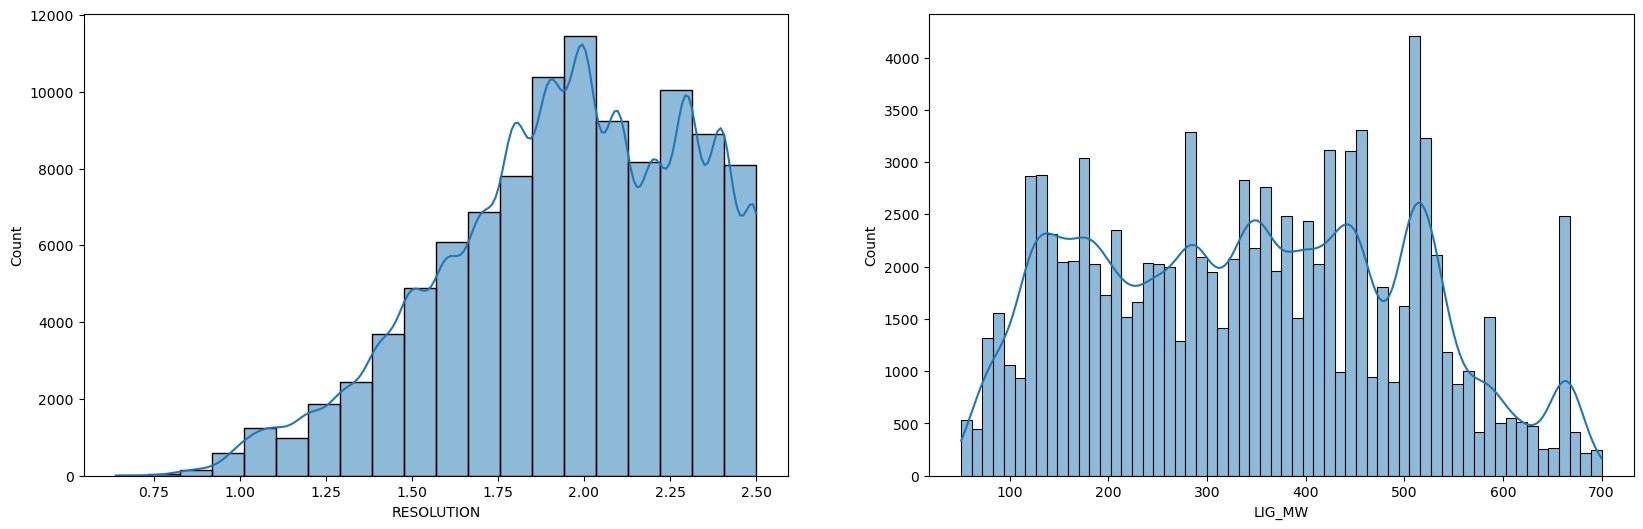

In [291]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
sns.histplot(data=pdb_data, x="RESOLUTION", bins=20, ax=ax[0], kde=True)
sns.histplot(data=pdb_data, x="LIG_MW", ax = ax[1], kde=True)

In [193]:
pdb_data.sample(10)

,PDB_ID,RESOLUTION,POLY_NAME,POLY_TYPE,POLY_CHAINS,IS_MEMBRANE,LIG_ID,LIG_CHAINS,LIG_NAME,LIG_SMILES,LIG_TYPE,LIG_MW,INVESTIGN?
96512,2C66,[2.5],AMINE OXIDASE (FLAVIN-CONTAINING) B,Protein,"['B', 'A']",True,FAD,"['B', 'A']",FLAVIN-ADENINE DINUCLEOTIDE,Cc1cc2c(cc1C)N(C3=NC(=O)NC(=O)C3=N2)C[C@@H]([C...,non-polymer,785.550,0.0
107250,5ODR,[2.2],"Heterodisulfide reductase, subunit A",Protein,"['G', 'A']",False,PE3,"['F', 'G', 'L']","3,6,9,12,15,18,21,24,27,30,33,36,39-TRIDECAOXA...",C(COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCO)O,non-polymer,634.751,0.0
127778,4NQE,[2.1],Beta-2-microglobulin,Protein,"['F', 'B']",False,2L4,"['C', 'A']","1-deoxy-1-({2,6-dioxo-5-[(E)-(2-oxoethylidene)...",C(C(C(C(CO)O)O)O)NC1=C(C(=O)NC(=O)N1)/N=C/C=O,non-polymer,316.267,0.0
104474,6JLL,[2.15],Photosystem II reaction center protein K,Protein,"['k', 'K']",True,SQD,"['a', 'f', 'A', 'F', 'b', 'B']","1,2-DI-O-ACYL-3-O-[6-DEOXY-6-SULFO-ALPHA-D-GLU...",CCCCCCCCCCCCCCCC(=O)OC[C@H](COC1[C@@H]([C@H]([...,non-polymer,795.116,0.0
174434,4O4J,[2.2],Tubulin beta-2B chain,Protein,"['B', 'D']",False,GDP,"['B', 'D']",GUANOSINE-5'-DIPHOSPHATE,c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=...,RNA linking,443.201,0.0
202304,3T2W,[1.5],Avidin/streptavidin,Protein,['A'],False,BTN,['A'],BIOTIN,C1[C@H]2[C@@H]([C@@H](S1)CCCCC(=O)O)NC(=O)N2,non-polymer,244.311,0.0
99943,5H2F,[2.2],Photosystem II CP47 reaction center protein,Protein,"['b', 'B']",True,LMT,"['E', 't', 'I', 'a', 'T', 'f', 'A', 'Z', 'B', ...",DODECYL-BETA-D-MALTOSIDE,CCCCCCCCCCCCO[C@H]1[C@@H]([C@H]([C@@H]([C@H](O...,D-saccharide,510.615,0.0
204096,2CZ0,[1.5],Nitrile hydratase subunit beta,Protein,['B'],False,BUA,['A'],BUTANOIC ACID,CCCC(=O)O,non-polymer,88.105,0.0
189248,5W5T,[1.76],Glucose-1-phosphate adenylyltransferase,Protein,"['P', 'A', 'B', 'R', 'J', 'N', 'Q', 'L', 'D', ...",False,9X7,"['L', 'I', 'M', 'O', 'A', 'D', 'F', 'Z', 'G', ...",ethyl 2-oxopropanoate,CCOC(=O)C(=O)C,non-polymer,116.115,0.0
18007,6A6U,[1.945],Fructosyl amine: oxygen oxidoreductase,Protein,['A'],False,FAD,['A'],FLAVIN-ADENINE DINUCLEOTIDE,Cc1cc2c(cc1C)N(C3=NC(=O)NC(=O)C3=N2)C[C@@H]([C...,non-polymer,785.550,0.0


# Most Common Ligands

In [293]:
lig_data = pd.DataFrame({'LIG_ID':pdb_data['LIG_ID'].value_counts().index, 'Count':pdb_data['LIG_ID'].value_counts()}).reset_index()
lig_data = pd.merge(lig_data, pdb_data.drop_duplicates(subset='LIG_ID'))[['LIG_ID','LIG_NAME','LIG_SMILES','LIG_MW','Count']]

In [294]:
lig_data

,LIG_ID,LIG_NAME,LIG_SMILES,LIG_MW,Count
0,FMN,FLAVIN MONONUCLEOTIDE,Cc1cc2c(cc1C)N(C3=NC(=O)NC(=O)C3=N2)C[C@@H]([C...,456.344,2118
1,ADP,ADENOSINE-5'-DIPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,427.201,1859
2,GDP,GUANOSINE-5'-DIPHOSPHATE,c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=...,443.201,1728
3,GTP,GUANOSINE-5'-TRIPHOSPHATE,c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=...,523.180,1685
4,LMT,DODECYL-BETA-D-MALTOSIDE,CCCCCCCCCCCCO[C@H]1[C@@H]([C@H]([C@@H]([C@H](O...,510.615,1521
...,...,...,...,...,...
27845,76X,"pyridine-2,3-diamine",c1cc(c(nc1)N)N,109.129,1
27846,TGX,"7-methyl-2H-1,4-benzothiazin-3(4H)-one",Cc1ccc2c(c1)SCC(=O)N2,179.239,1
27847,CMQ,"N~2~-[(BENZYLOXY)CARBONYL]-N-[(1S,2S)-2-HYDROX...",CC(C)C[C@@H](C(=O)N[C@@H](Cc1ccc(cc1)O)[C@H](C...,428.521,1
27848,KGT,N-(4-carboxy-4-oxobutanoyl)-L-cysteinylglycine,C(CC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)C(=O)O,306.292,1


In [359]:
def plot_common_ligands(lig_data):
    fig, ax = plt.subplots(figsize=(15,6))
    ax= sns.barplot(data=lig_data.head(50), x='LIG_ID', y='Count',
                    linewidth=1,edgecolor="black")
    ax.grid(color='lightgrey', ls="--")
    plt.xticks(rotation = 90);
    return

In [296]:
lig_data.head(40)

,LIG_ID,LIG_NAME,LIG_SMILES,LIG_MW,Count
0,FMN,FLAVIN MONONUCLEOTIDE,Cc1cc2c(cc1C)N(C3=NC(=O)NC(=O)C3=N2)C[C@@H]([C...,456.344,2118
1,ADP,ADENOSINE-5'-DIPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,427.201,1859
2,GDP,GUANOSINE-5'-DIPHOSPHATE,c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=...,443.201,1728
3,GTP,GUANOSINE-5'-TRIPHOSPHATE,c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=...,523.180,1685
4,LMT,DODECYL-BETA-D-MALTOSIDE,CCCCCCCCCCCCO[C@H]1[C@@H]([C@H]([C@@H]([C@H](O...,510.615,1521
5,BCR,BETA-CAROTENE,CC1=C(C(CCC1)(C)C)\C=C\C(=C\C=C\C(=C\C=C\C=C(/...,536.873,1509
6,NAD,NICOTINAMIDE-ADENINE-DINUCLEOTIDE,c1cc(c[n+](c1)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[...,663.425,1444
7,OEX,CA-MN4-O5 CLUSTER,O1[Mn][O@]23[Mn@@]14[O@]5[Ca]2[O@@]6[Mn]5[O@]4...,339.827,1234
8,ATP,ADENOSINE-5'-TRIPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,507.181,1196
9,SAH,S-ADENOSYL-L-HOMOCYSTEINE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,384.411,975


# Ligand Atom Types

In [297]:
# -- RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole
print("RDKit Version: ", rdkit.__version__)

RDKit Version:  2022.09.5


In [331]:
from collections import defaultdict

def count_ligand_atoms(df):
    atom_present_in_entries = defaultdict(lambda:0)

    for lig in tqdm(df.index):
        smi = df.loc[lig].LIG_SMILES
        try:
            mol = Chem.MolFromSmiles(smi, sanitize=False)
            if mol:
                atom_present_in_mol = defaultdict(lambda : False)
                for atom in mol.GetAtoms():
                     atom_present_in_mol[atom.GetSymbol()] = True
            #    print(atom_present_in_mol)

                for atom in atom_present_in_mol.keys():
                    atom_present_in_entries[atom] += df.loc[lig].Count
        except:
            pass
    atom_present_in_entries.pop('H',None)
    return pd.DataFrame({"ATOM":atom_present_in_entries.keys(),
                           "N_ENTRIES":atom_present_in_entries.values()}).sort_values(by="N_ENTRIES", ascending=False)

In [361]:
def plot_ligand_atom_data(atom_count):
    fig, ax = plt.subplots(figsize=(15,6))
    ax= sns.barplot(data=atom_count.head(40), x='ATOM', y='N_ENTRIES',
                    linewidth=1,edgecolor="black")
    ax.grid(color='lightgrey', ls="--")
    for i in ax.containers:
        ax.bar_label(i, rotation=45)
    return

## Remove entries where the ligand has atoms beyond the MedChem set

In [258]:
medchem_atoms = ['C','N','O','H','S','P','F','Cl','Br','I']

In [346]:
def has_invalid_atoms(smiles):
    invalid = False
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        if mol:
            for atom in mol.GetAtoms():
                symb = atom.GetSymbol()
                #print(f"{symb}, ", end="")
                if atom.GetSymbol() not in medchem_atoms: 
                    invalid = True
        else:
            invalid = True
    except:
        invalid = True
    return invalid

In [342]:
for smi in lig_data.sample(5).LIG_SMILES:
    has_invalid_atoms(lig)

In [343]:
lig_data['HAS_INVALID_SMILES'] = lig_data.LIG_SMILES.apply(has_invalid_atoms)

In [347]:
len(lig_data), lig_data.HAS_INVALID_SMILES.sum()

(27850, 898)

In [348]:
lig_data.loc[ lig_data.HAS_INVALID_SMILES == True ]

,LIG_ID,LIG_NAME,LIG_SMILES,LIG_MW,Count,HAS_INVALID_SMILES
7,OEX,CA-MN4-O5 CLUSTER,O1[Mn][O@]23[Mn@@]14[O@]5[Ca]2[O@@]6[Mn]5[O@]4...,339.827,1234,True
11,CUA,DINUCLEAR COPPER ION,[Cu][Cu],127.092,845,True
22,OEY,CA-MN4-O6 CLUSTER,O1O23[Ca]4O5[Mn]1O6[Mn]5O4[Mn]62O[Mn]3,355.827,520,True
50,CU1,COPPER (I) ION,[Cu+],63.546,182,True
60,FCO,CARBONMONOXIDE-(DICYANO) IRON,C(#N)[Fe](=C=O)C#N,135.890,150,True
...,...,...,...,...,...,...
27724,HE6,"6,7-DICARBOXYL-1,2,3,4,5,8-HEXAMETHYLHEMIN",Cc1c(c2n3c1C=C4C(=C(C5=[N]4[Fe]36[N]7=C(C=C8N6...,536.360,1,True
27772,35N,Copper(II) tetrapyrrole,c1ccn(c1)[Cu](n2cccc2)(n3cccc3)n4cccc4,327.871,1,True
27773,PT7,chloro[2-(pyridin-2-yl-kappaN)phenyl-kappaC~1~...,c1ccc(cc1)[P](c2ccccc2)(c3ccccc3)[Pt+2]4(c5ccc...,647.004,1,True
27786,DAA,8-AMINO-7-CARBOXYAMINO-NONANOIC ACID WITH ALUM...,C[C@@H]([C@@H](CCCCCC(=O)O)NC(=O)O[Al-](F)(F)F)N,315.246,1,True


In [351]:
invalid_atoms_ligands = lig_data.loc[ lig_data.HAS_INVALID_SMILES == True ].copy(deep=True)

In [352]:
invalid_atoms_ligands

,LIG_ID,LIG_NAME,LIG_SMILES,LIG_MW,Count,HAS_INVALID_SMILES
7,OEX,CA-MN4-O5 CLUSTER,O1[Mn][O@]23[Mn@@]14[O@]5[Ca]2[O@@]6[Mn]5[O@]4...,339.827,1234,True
11,CUA,DINUCLEAR COPPER ION,[Cu][Cu],127.092,845,True
22,OEY,CA-MN4-O6 CLUSTER,O1O23[Ca]4O5[Mn]1O6[Mn]5O4[Mn]62O[Mn]3,355.827,520,True
50,CU1,COPPER (I) ION,[Cu+],63.546,182,True
60,FCO,CARBONMONOXIDE-(DICYANO) IRON,C(#N)[Fe](=C=O)C#N,135.890,150,True
...,...,...,...,...,...,...
27724,HE6,"6,7-DICARBOXYL-1,2,3,4,5,8-HEXAMETHYLHEMIN",Cc1c(c2n3c1C=C4C(=C(C5=[N]4[Fe]36[N]7=C(C=C8N6...,536.360,1,True
27772,35N,Copper(II) tetrapyrrole,c1ccn(c1)[Cu](n2cccc2)(n3cccc3)n4cccc4,327.871,1,True
27773,PT7,chloro[2-(pyridin-2-yl-kappaN)phenyl-kappaC~1~...,c1ccc(cc1)[P](c2ccccc2)(c3ccccc3)[Pt+2]4(c5ccc...,647.004,1,True
27786,DAA,8-AMINO-7-CARBOXYAMINO-NONANOIC ACID WITH ALUM...,C[C@@H]([C@@H](CCCCCC(=O)O)NC(=O)O[Al-](F)(F)F)N,315.246,1,True


In [355]:
for ligid in tqdm(invalid_atoms_ligands.LIG_ID):
    indexes_to_drop = pdb_data[ pdb_data.LIG_ID == ligid ].index
    pdb_data.drop(index=indexes_to_drop, inplace=True)

  0%|          | 0/898 [00:00<?, ?it/s]

In [356]:
count_entries(pdb_data)

Total # records        :  96326
Unique PDBIDs          :  58816
Membrane Proteins      :  2069


<Axes: xlabel='LIG_MW', ylabel='Count'>

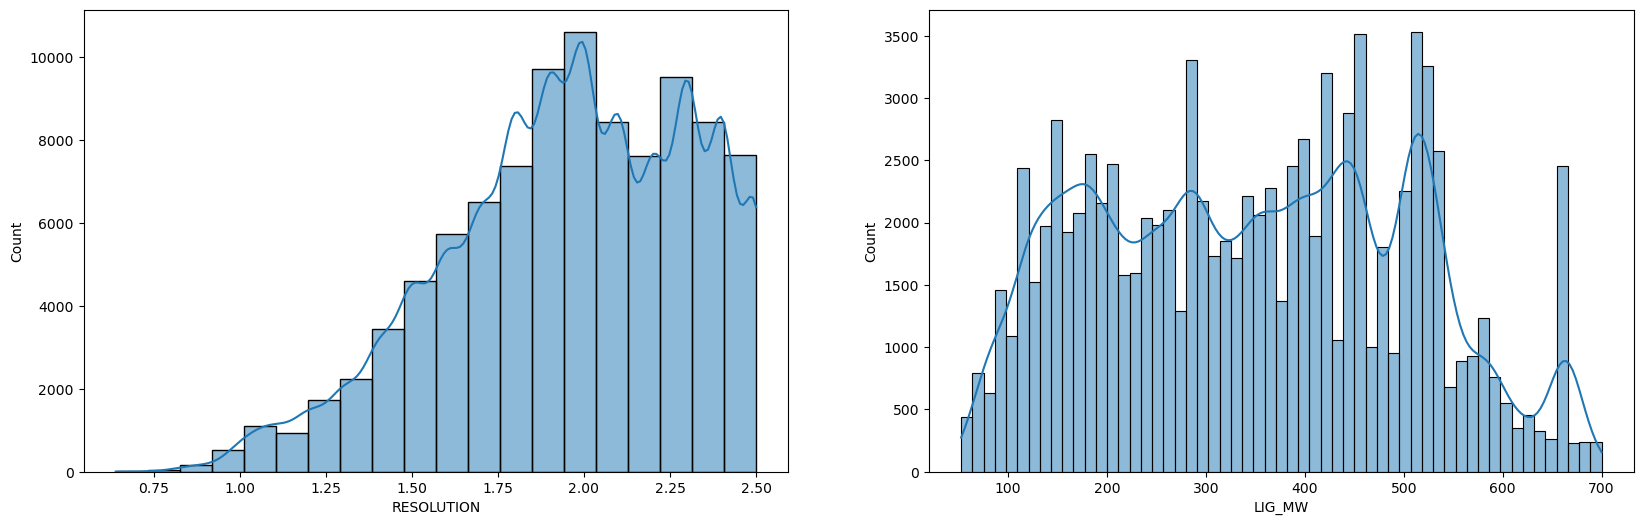

In [365]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
sns.histplot(data=pdb_data, x="RESOLUTION", bins=20, ax=ax[0], kde=True)
sns.histplot(data=pdb_data, x="LIG_MW", ax = ax[1], kde=True)

# Check the ligands again

In [357]:
lig_data = pd.DataFrame({'LIG_ID':pdb_data['LIG_ID'].value_counts().index, 'Count':pdb_data['LIG_ID'].value_counts()}).reset_index()
lig_data = pd.merge(lig_data, pdb_data.drop_duplicates(subset='LIG_ID'))[['LIG_ID','LIG_NAME','LIG_SMILES','LIG_MW','Count']]

In [358]:
len(lig_data)

26952

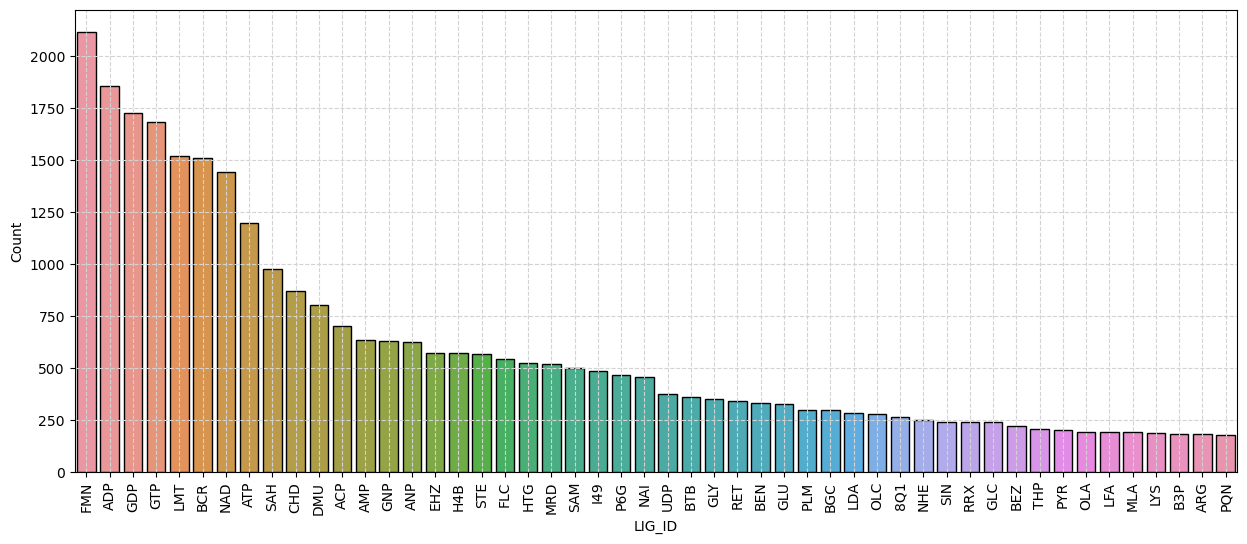

In [360]:
plot_common_ligands(lig_data)

  0%|          | 0/26952 [00:00<?, ?it/s]

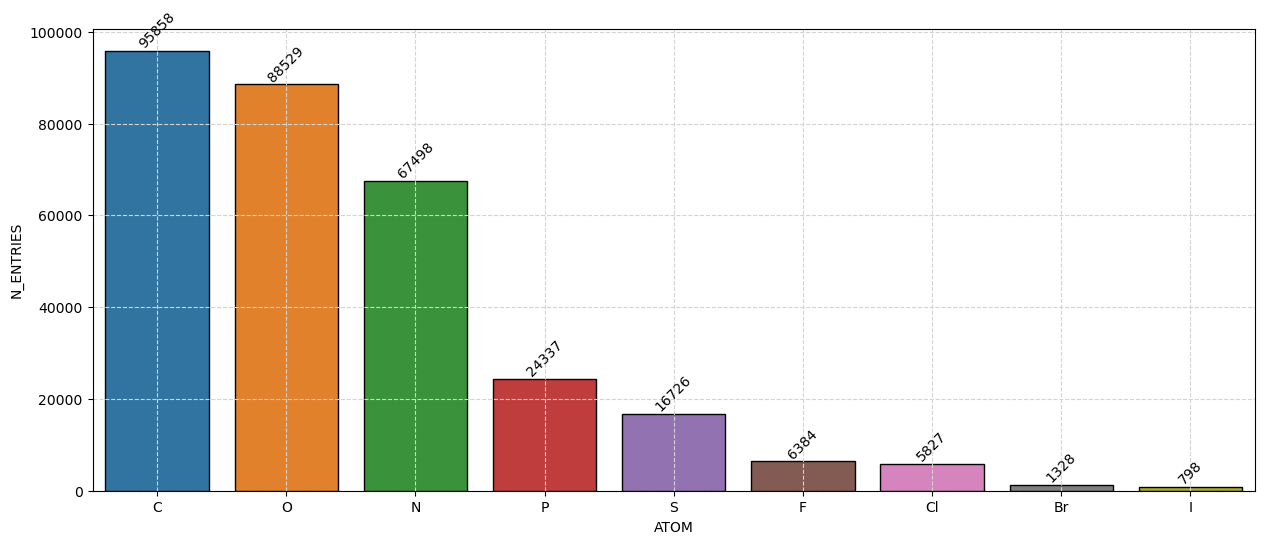

In [362]:
atom_count = count_ligand_atoms(lig_data)
plot_ligand_atom_data(atom_count)

(this shows how many DataFrame rows contains ligands with at last one of those atoms. A single PDBID may have multiple instances of ligands, resulting in more instances of the atoms than unique PDBIDs.)

# Cofactors

One unresolved question so far is the inclusion or not of cofactors in the database. 

1. Cofactors repeat multiple times, so their environment may impose a bias in the training.
1. However, they **are** small organic molecules, so maybe they should be considered?

Here, we create a separate table with cofactors. Traning can be done with or without them, and then results compared.

In [374]:
response = requests.get("https://www.ebi.ac.uk/pdbe/api/pdb/compound/cofactors").json()

In [381]:
cofactors = {'LIG_ID':[], 'LIG_NAME':[]}
for key in response.keys():
    for cofactor in response[key][0]['cofactors']:
        cofactors['LIG_ID'].append(cofactor)
        cofactors['LIG_NAME'].append(key)

In [404]:
pd.DataFrame(cofactors)

,LIG_ID,LIG_NAME
0,ASC,Ascorbic acid
1,F43,Factor F430
2,M43,Factor F430
3,MDO,MIO
4,PNS,Phosphopantetheine
...,...,...
360,P2Q,Topaquinone
361,P3Q,Topaquinone
362,TPQ,Topaquinone
363,TYQ,Topaquinone


In [405]:
_ = pd.DataFrame(cofactors)
_.loc[_['LIG_ID'] == 'ATP']

,LIG_ID,LIG_NAME


In [424]:
columns = 20
count = 0
row=1
for col in range(0, columns+1):
    print(str(col) + '\t', end='')
print('\n')
print(f'{row}\t', end='')
for ligid in _['LIG_ID'].dropna().sort_values():
    print(ligid + '\t', end='')
    count += 1
    if count == columns: 
        count = 0
        row +=1
        print(f'\n{row}\t', end='')

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	

1	01A	01K	0AF	0ET	0HG	0HH	0UM	0WD	0XU	0Y0	0Y1	0Y2	18W	1C4	1CV	1CZ	1DG	1HA	1JO	1JP	
2	1R4	1TP	1TY	1U0	1VU	1XE	1YJ	29P	2CP	2MD	2NE	2TP	2TY	36A	37H	3AA	3CD	3CP	3GC	3H9	
3	3HC	48T	4AB	4CA	4CO	4IK	4LS	4LU	4YP	5AU	5GY	62X	6FA	6HE	6NR	6V0	76H	76J	76K	76L	
4	76M	7AP	7HE	8EF	8EL	8EO	8FL	8ID	8JD	8PA	8Z2	A3D	ABY	ACO	AGQ	AHE	AMX	AP0	ASC	AT5	
5	ATA	B12	BCA	BCO	BHS	BIO	BOB	BSJ	BTI	BTN	BYC	BYG	BYT	C2F	CA3	CA5	CA6	CA8	CAA	CAJ	
6	CAO	CCH	CIC	CMC	CMX	CNC	CND	CO6	CO8	COA	COB	COD	COF	COH	COM	COO	COT	COW	COY	COZ	
7	D7K	DCA	DCC	DDH	DG1	DHE	DN4	DPM	DTB	EAD	EEM	EN0	ENA	EPY	ESG	F43	FA8	FAA	FAB	FAD	
8	FAE	FAM	FAO	FAS	FCG	FCX	FDA	FDE	FED	FFO	FMI	FMN	FNR	FNS	FON	FOZ	FRE	FSH	FYN	G27	
9	GBI	GBP	GBX	GDN	GDS	GF5	GGC	GIP	GNB	GPR	GPS	GRA	GS8	GSB	GSF	GSH	GSM	GSN	GSO	GTB	
10	GTD	GTS	GTX	GTY	GVX	H2B	H4B	HAG	HAS	HAX	HBI	HCC	HDD	HDE	HEA	HEB	HEC	HEM	HIF	HMG	
11	HSC	HTL	HXC	IBG	ICY	IRF	ISW	JM2	JM5	JM7	K15	L9X	LEE	LNC	LPA	LPB	LZ6	M43	M6T	MCA	
12	MCD	MCN	MDE	MDO	MGD	MH0	MLC

So, the PDBe has 364 names associated with "cofactor-like" molecules. We can use that to split our database into small-molecules and cofactor-like molecules 

In [393]:
pdb_with_cofactors = pd.DataFrame(columns=pdb_data.columns)
pdb_wout_cofactors = pdb_data.copy(deep=True)

for cof in tqdm(cofactors['LIG_ID']):
    cofactor_indexes = pdb_wout_cofactors[ pdb_wout_cofactors.LIG_ID == cof ].index
    
    pdb_with_cofactors = pdb_with_cofactors.merge(pdb_wout_cofactors.loc[cofactor_indexes], how='outer')
    pdb_wout_cofactors.drop( index=cofactor_indexes, inplace=True )

  0%|          | 0/365 [00:00<?, ?it/s]

In [394]:
pdb_with_cofactors

,PDB_ID,RESOLUTION,POLY_NAME,POLY_TYPE,POLY_CHAINS,IS_MEMBRANE,LIG_ID,LIG_CHAINS,LIG_NAME,LIG_SMILES,LIG_TYPE,LIG_MW,INVESTIGN?
0,2YLD,1.250,CYTOCHROME C',Protein,['A'],False,ASC,['A'],ASCORBIC ACID,C([C@@H]([C@@H]1C(=C(C(=O)O1)O)O)O)O,L-saccharide,176.124,0.0
1,4GPC,1.850,Heme oxygenase,Protein,"['B', 'C', 'A']",False,ASC,['C'],ASCORBIC ACID,C([C@@H]([C@@H]1C(=C(C(=O)O1)O)O)O)O,L-saccharide,176.124,0.0
2,4JTP,1.850,rRNA N-glycosidase,Protein,['A'],False,ASC,['A'],ASCORBIC ACID,C([C@@H]([C@@H]1C(=C(C(=O)O1)O)O)O)O,L-saccharide,176.124,0.0
3,8DJT,1.160,L-ascorbate peroxidase,Protein,['A'],False,ASC,['A'],ASCORBIC ACID,C([C@@H]([C@@H]1C(=C(C(=O)O1)O)O)O)O,L-saccharide,176.124,1.0
4,4O79,2.003,Probable transmembrane ascorbate ferrireductase 2,Protein,"['B', 'A']",True,ASC,['B'],ASCORBIC ACID,C([C@@H]([C@@H]1C(=C(C(=O)O1)O)O)O)O,L-saccharide,176.124,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7828,6AJX,1.887,Bromodomain-containing protein 4,Protein,['A'],False,HCC,['A'],"2',4,4'-TRIHYDROXYCHALCONE",c1cc(ccc1C=CC(=O)c2ccc(cc2O)O)O,non-polymer,256.253,1.0
7829,4RLU,2.198,(3R)-hydroxyacyl-ACP dehydratase subunit HadA,Protein,['A'],False,HCC,['A'],"2',4,4'-TRIHYDROXYCHALCONE",c1cc(ccc1C=CC(=O)c2ccc(cc2O)O)O,non-polymer,256.253,0.0
7830,4RLU,2.198,(3R)-hydroxyacyl-ACP dehydratase subunit HadB,Protein,['B'],False,HCC,['A'],"2',4,4'-TRIHYDROXYCHALCONE",c1cc(ccc1C=CC(=O)c2ccc(cc2O)O)O,non-polymer,256.253,0.0
7831,6AJV,1.450,Bromodomain-containing protein 4,Protein,['A'],False,HCC,['A'],"2',4,4'-TRIHYDROXYCHALCONE",c1cc(ccc1C=CC(=O)c2ccc(cc2O)O)O,non-polymer,256.253,1.0


In [395]:
pdb_wout_cofactors

,PDB_ID,RESOLUTION,POLY_NAME,POLY_TYPE,POLY_CHAINS,IS_MEMBRANE,LIG_ID,LIG_CHAINS,LIG_NAME,LIG_SMILES,LIG_TYPE,LIG_MW,INVESTIGN?
0,7OKC,1.84,Acyl-[acyl-carrier-protein]--UDP-N-acetylgluco...,Protein,['A'],False,VFE,['A'],"2-[2-(2-chlorophenyl)sulfanylethanoyl-[[4-(1,2...",CNC(=O)CN(Cc1ccc(cc1)n2cncn2)C(=O)CSc3ccccc3Cl,non-polymer,429.923,1.0
2,2IYS,1.40,SHIKIMATE KINASE,Protein,['A'],False,SKM,['A'],"(3R,4S,5R)-3,4,5-TRIHYDROXYCYCLOHEX-1-ENE-1-CA...",C1[C@H]([C@@H]([C@@H](C=C1C(=O)O)O)O)O,non-polymer,174.151,0.0
7,4O2P,2.10,Proto-oncogene tyrosine-protein kinase Src,Protein,"['B', 'A']",False,11V,"['B', 'A']",1-[(2R)-2-chloro-2-phenylethyl]-6-{[2-(morphol...,c1ccc(cc1)[C@H](Cn2c3c(cn2)c(nc(n3)SCCN4CCOCC4...,non-polymer,495.039,0.0
8,3FIT,2.40,FRAGILE HISTIDINE PROTEIN,Protein,['A'],False,FRU,['A'],beta-D-fructofuranose,C([C@@H]1[C@H]([C@@H]([C@](O1)(CO)O)O)O)O,"D-saccharide, beta linking",180.156,0.0
9,3FIT,2.40,FRAGILE HISTIDINE PROTEIN,Protein,['A'],False,A,['A'],ADENOSINE-5'-MONOPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,RNA linking,347.221,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225231,3UB5,2.20,"Actin, cytoplasmic 1",Protein,['A'],False,ATP,['A'],ADENOSINE-5'-TRIPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,non-polymer,507.181,0.0
225234,3UB5,2.20,Profilin-1,Protein,['P'],False,ATP,['A'],ADENOSINE-5'-TRIPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,non-polymer,507.181,0.0
225237,7JKW,1.20,Bromodomain-containing protein 4,Protein,['A'],False,VCV,['A'],N-(6-{5-[(azetidin-3-yl)amino]-1-methyl-6-oxo-...,CCS(=O)(=O)Nc1cc(cc2c1ccn2C(C)(c3ccccn3)c4cccc...,non-polymer,583.704,1.0
225241,1Z5M,2.17,3-phosphoinositide dependent protein kinase-1,Protein,['A'],False,LI8,['A'],N-(3-{[5-BROMO-2-({3-[(PYRROLIDIN-1-YLCARBONYL...,CC(C)(C(=O)N)C(=O)NCCCNc1c(cnc(n1)Nc2cccc(c2)N...,non-polymer,547.448,0.0


In [396]:
count_entries(pdb_data)

Total # records        :  96326
Unique PDBIDs          :  58816
Membrane Proteins      :  2069


In [397]:
count_entries(pdb_with_cofactors)

Total # records        :  7833
Unique PDBIDs          :  5720
Membrane Proteins      :  100


In [398]:
count_entries(pdb_wout_cofactors)

Total # records        :  88493
Unique PDBIDs          :  55841
Membrane Proteins      :  2057


In [401]:
small_lig_data = pd.DataFrame({'LIG_ID':pdb_wout_cofactors['LIG_ID'].value_counts().index, 'Count':pdb_wout_cofactors['LIG_ID'].value_counts()}).reset_index()
small_lig_data = pd.merge(small_lig_data, pdb_wout_cofactors.drop_duplicates(subset='LIG_ID'))[['LIG_ID','LIG_NAME','LIG_SMILES','LIG_MW','Count']]

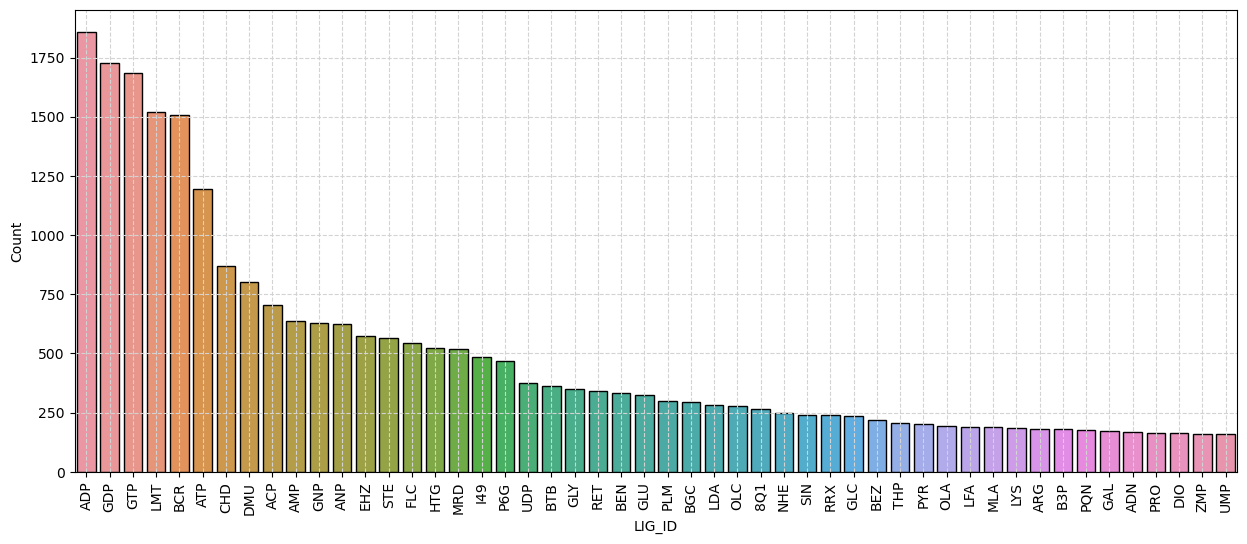

In [402]:
plot_common_ligands(small_lig_data)

It would seem that some important cofactors such as ATP, ADP, GDP, etc. are *not* included in the PDBe cofactor list!

In [406]:
cofactor_data = pd.DataFrame({'LIG_ID':pdb_with_cofactors['LIG_ID'].value_counts().index, 'Count':pdb_with_cofactors['LIG_ID'].value_counts()}).reset_index()
cofactor_data = pd.merge(cofactor_data, pdb_with_cofactors.drop_duplicates(subset='LIG_ID'))[['LIG_ID','LIG_NAME','LIG_SMILES','LIG_MW','Count']]

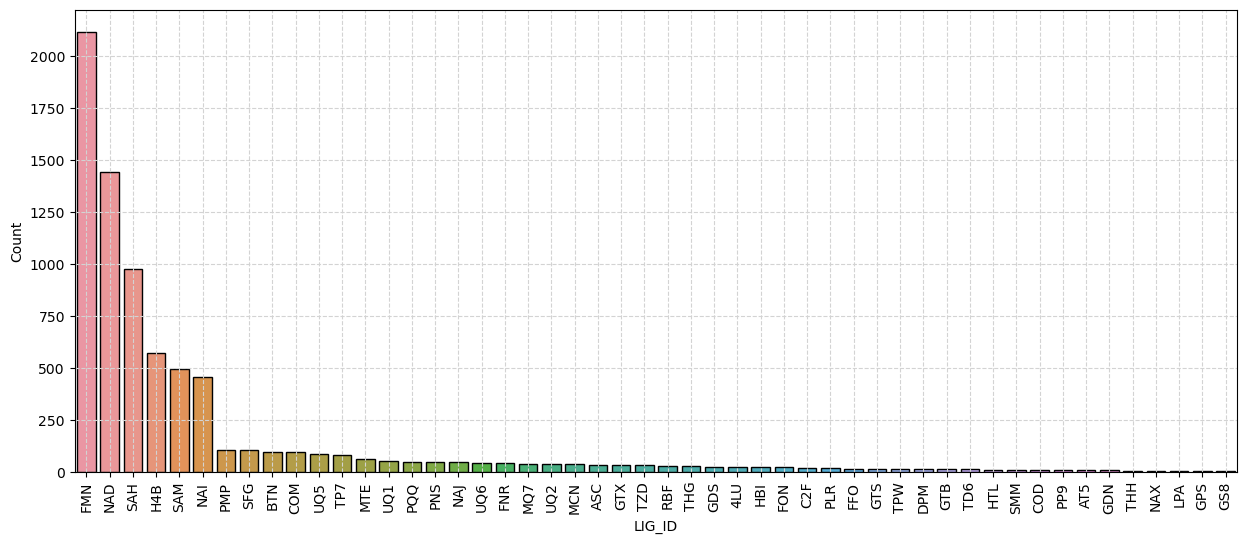

In [407]:
plot_common_ligands(cofactor_data)

In [425]:
len(pdb_data.drop_duplicates(subset=['PDB_ID','LIG_ID']))

72843